In [1]:
from __future__ import division, print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from hyper_dynamics import HyperDynamics, HDynamicsParams
import time as tm
import os

rng = np.random.RandomState()
np.random.seed(44)

In [2]:
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1
def pot0(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-0.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-0.)/.8)**2) )
def pot1(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-3.)/.5)**2 - tf.log(tf.exp(-.5*((z[0]-3.)/.5)**2) + tf.exp(-.5*((z[0]+3.)/.5)**2))
def pot2(z):
    z = tf.transpose(z)
    return .5*((z[1]-w1(z))/.4)**2
def pot3(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.35)**2) + tf.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
def pot4(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.4)**2) + tf.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))
def banana(z):
    z = tf.transpose(z)
    return ( .5*(z[0]**2 + z[1]**2) + .5*.8 * (25.*z[0] + z[1]**2 - 0.)**2 ) * .01

# Global Parameters

In [3]:
num_latent = 2; num_particles = 50
num_fig = 5; num_iter = 300
# get_logp = lambda z: -pot1(z); logp_name = 'pot1'
get_logp = lambda z: -banana(z); logp_name = 'banana'
savefig = False
plt_limx = [-7,3]; plt_limy = [-9,9] # = plt_limx
plt_nptx = 50
plt_npty = int(plt_nptx * (plt_limx[1]-plt_limx[0]) / float(plt_limy[1]-plt_limy[0]))
mmt_plt = False
mmt_limx = [-8,8]; mmt_limy = mmt_limx
mmt_nptx = 50
mmt_npty = int(mmt_nptx * (mmt_limx[1]-mmt_limx[0]) / float(mmt_limy[1]-mmt_limy[0]))

In [4]:
samples0 = np.random.randn(num_particles, num_latent) * .5 + np.array([-2, -7])
samples_tf = tf.Variable(samples0)

side_x = np.linspace(plt_limx[0], plt_limx[1], plt_nptx)
side_y = np.linspace(plt_limy[0], plt_limy[1], plt_npty)
mesh_z1, mesh_z2 = np.meshgrid(side_x, side_y)
zv = np.hstack([mesh_z1.reshape(-1, 1), mesh_z2.reshape(-1, 1)])
zp_tf  = tf.placeholder(tf.float32, [None, num_latent])
prob_tf = tf.exp(get_logp(zp_tf))
with tf.Session() as sess:
    phat_z = sess.run(prob_tf, feed_dict={zp_tf: zv}) 
phat_z = phat_z.reshape([plt_npty, plt_nptx])
z_min, z_max = -np.abs(phat_z).max(), np.abs(phat_z).max()
zbkgn_tup = (mesh_z1, mesh_z2, phat_z, z_max, plt_limx, plt_limy)

def mmt_bkgn(isig1, isig2 = None):
    isig = np.array([isig1, isig1 if isig2 is None else isig2])
    mmt_side_x = np.linspace(mmt_limx[0], mmt_limx[1], mmt_nptx)
    mmt_side_y = np.linspace(mmt_limy[0], mmt_limy[1], mmt_npty)
    mesh_mmt1, mesh_mmt2 = np.meshgrid(mmt_side_x, mmt_side_y)
    phat_mmt = (np.prod(isig)/2./np.pi) * np.exp(-.5*(isig[0]*(mesh_mmt1**2) + isig[1]*(mesh_mmt2**2)))
    mmt_max = np.abs(phat_mmt).max()
    return mesh_mmt1, mesh_mmt2, phat_mmt, mmt_max, mmt_limx, mmt_limy

def exec_plot(ax, samples, mesh1, mesh2, phat, vmax, limx, limy):
    ax.set_xlim(limx); ax.set_ylim(limy)
    ax.set_aspect('equal'); ax.set_xticks([]); ax.set_yticks([])
    #ax.pcolormesh(mesh1, mesh2, phat, cmap='RdBu', vmin=vmin, vmax=vmax)
    ax.contourf(mesh1, mesh2, phat, cmap='Blues', vmin=0, vmax=vmax*1.8)
    ax.scatter(samples[:,0], samples[:,1], c='dimgrey', marker="o", s=30, linewidths=0, edgecolor='white', alpha=1)
    
def showfig_smp_orig(op_samples, dninfo):
    fig, ax = plt.subplots(1, num_fig, sharey=True, sharex=True, figsize=(2.2*num_fig,4))#(6,6)
    plt.subplots_adjust(wspace=.015)
    if num_fig == 1:
        figrange = [0]; ax = [ax]
    else:
        figrange = range(1, num_fig)
        exec_plot(ax[0], samples0, *zbkgn_tup)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in figrange:
            for j in range(num_iter-1): sess.run(op_samples)
            samples = sess.run([op_samples, dninfo.L_samples])[1][0]
            exec_plot(ax[i], samples, *zbkgn_tup)
    return fig, ax

def showfig_smp_mmt(op_samples, dninfo):
    fig, ax = plt.subplots(2, num_fig, figsize=(2*num_fig,8))#(6,6)
    if num_fig == 1:
        figrange = [0]; ax = [[ax[0]], [ax[1]]]
    else:
        figrange = range(1, num_fig)
        exec_plot(ax[0][0], samples0, *zbkgn_tup)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        mmtbkgn_tup = mmt_bkgn(dninfo.L_invSigma[0].eval())
        if num_fig > 1:
            mmt = sess.run(dninfo.L_momentum)[0]
            exec_plot(ax[1][0], mmt, *mmtbkgn_tup)
        for i in figrange:
            for j in range(num_iter-1): sess.run(op_samples)
            res = sess.run([op_samples, dninfo.L_samples, dninfo.L_momentum])
            exec_plot(ax[0][i], res[1][0], *zbkgn_tup)
            exec_plot(ax[1][i], res[2][0], *mmtbkgn_tup)
    return fig, ax

def showfig_smp(pm):
    t0 = tm.time()
    dn_op, dninfo = HyperDynamics(pm).evolve(samples_tf, get_logp=get_logp)
    fig, ax = showfig_smp_mmt(dn_op, dninfo) if mmt_plt and hasattr(dninfo, 'L_momentum') else showfig_smp_orig(dn_op, dninfo)
    t1 = tm.time(); print(t1-t0)
    if savefig:
        dirname = './synth_res_' + logp_name + '/'
        if not os.path.isdir(dirname): os.makedirs(dirname)
        fig.savefig( dirname \
            + '_'.join([pm.hyperType, pm.dnType, pm.bwType if hasattr(pm, 'bwType') else 'void', pm.optType]) \
            + '.pdf', bbox_inches='tight')
    # return fig, ax

# LD

4.79399514198


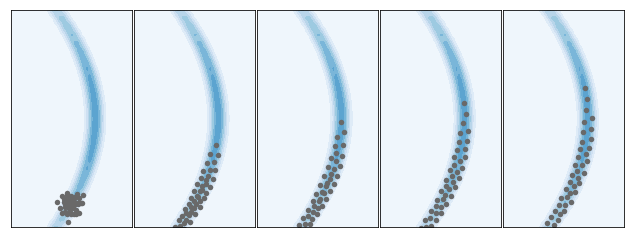

In [5]:
showfig_smp(HDynamicsParams(
    'LD', 'Blob', 'gd', 'he', 1e-2,
))

# SGHMC-1

1.6883251667


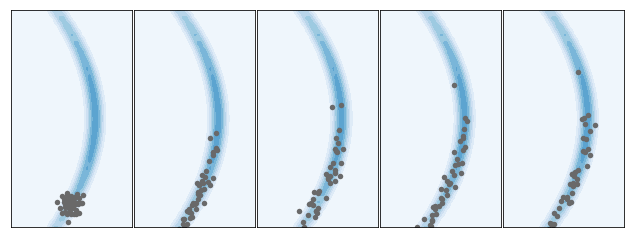

In [6]:
showfig_smp(HDynamicsParams(
    'SGHMC-1', 'LD', 'gd', 'he', 1e-2,
    invSigma = 1., diffuC = .5, dnRidge = 1e-2))

3.58832502365


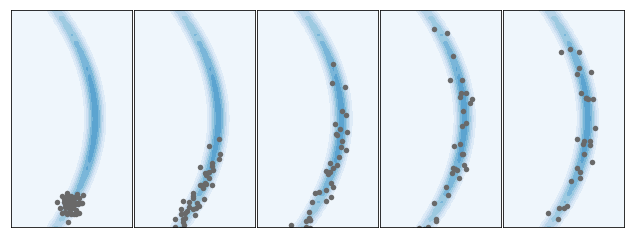

In [7]:
showfig_smp(HDynamicsParams(
    'SGHMC-1', 'Blob', 'gd', 'he', 1e-2,
    invSigma = 1., diffuC = .5, dnRidge = 1e-2))

# SGHMC-2

5.75002908707


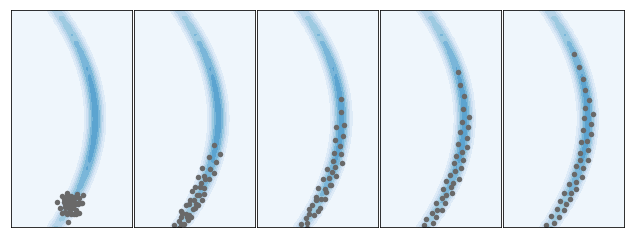

In [8]:
showfig_smp(HDynamicsParams(
    'SGHMC-2', 'Blob', 'gd', 'he', 1e-2,
    invSigma = 1., diffuC = .5, dnRidge = 1e-2))